In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
import neptune

%load_ext autoreload
%autoreload 2

from src.features import *
from src.utils import *
from src.models import *
from src.optimizers import *
from src.loss_functions import *
from src.dataloaders import *
from src.security import NEPTUNE_TOKEN
from src.pipeline_functions import *

plt.style.use("ggplot")
# show all columns
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SEED = 45
set_seed(SEED)

In [3]:
stocks = ["SPY", "VTV", "VUG", "VYM", "QQQ", "VNQ", "GLD", "AGG", "SOXX", "OIH", "IYT", "XLF", "XLV", "VOX", "XLY", "XLP", "BND", "BSV", "IEMG", "VEA", "VWO"]
stocks = sorted(stocks)

stock_classes = {'AGG': 'EQUITY', 'GLD': 'COMMODITY', 'IYT': 'EQUITY', 'OIH': 'EQUITY', 'QQQ': 'EQUITY',
                 'SOXX': 'EQUITY', 'SPY': 'EQUITY', 'VNQ': 'REAL_ESTATE', 'VOX': 'EQUITY', 'VTV': 'EQUITY',
                 'VUG': 'EQUITY', 'VYM': 'EQUITY', 'XLF': 'EQUITY', 'XLP': 'EQUITY', 'XLV': 'EQUITY', 'XLY': 'EQUITY',
                 "BND": "FIXED_INCOME", "BSV": "FIXED_INCOME", "IEMG": "EQUITY", "VEA": "EQUITY", "VWO": "EQUITY"
}

classes_color = {'EQUITY': 'salmon', 'COMMODITY': 'cyan', 'FIXED_INCOME': 'lightgreen', "REAL_ESTATE": "lightblue"}

len(stocks)

21

In [4]:
path = "C:\\Users\\Андрей\\Documents\\diploma_python\\data"

df_adj_close, df_close, df_high, df_low, df_volume = get_data(path, stocks)

AGG Start of history: 2003-09-29
BND Start of history: 2007-04-10
BSV Start of history: 2007-04-10
GLD Start of history: 2004-11-18
IEMG Start of history: 2012-10-24
IYT Start of history: 2004-01-02
OIH Start of history: 2001-02-26
QQQ Start of history: 1999-03-10
SOXX Start of history: 2001-07-13
SPY Start of history: 1993-01-29
VEA Start of history: 2007-07-26
VNQ Start of history: 2004-09-29
VOX Start of history: 2004-09-29
VTV Start of history: 2004-01-30
VUG Start of history: 2004-01-30
VWO Start of history: 2005-03-10
VYM Start of history: 2006-11-16
XLF Start of history: 1998-12-22
XLP Start of history: 1998-12-22
XLV Start of history: 1998-12-22
XLY Start of history: 1998-12-22


In [5]:
nodes_matrix, combined_adj_matrix, cov_adj_matrix, future_return, df_return, df_features = features_pipeline(df_adj_close, df_close, df_high, df_low, df_volume, stocks=stocks)

Features generated and scaled
Return features generated
Correlation and covariance matrices generated
Common index length 2416


100%|██████████| 2416/2416 [05:31<00:00,  7.29it/s]


Adjacency matrices generated
Pipeline finished


In [6]:
TRAIN = 1800
PERIOD = 90 #max window for features' calculation

train_dataset = Dataset(nodes_matrix[:TRAIN], 
                          combined_adj_matrix[:TRAIN], 
                          cov_adj_matrix[:TRAIN], 
                          future_return[:TRAIN])

test_dataset = Dataset(nodes_matrix[TRAIN+PERIOD:],
                            combined_adj_matrix[TRAIN+PERIOD:],
                            cov_adj_matrix[TRAIN+PERIOD:],
                            future_return[TRAIN+PERIOD:])

len(test_dataset)

526

In [43]:
model = BareModel(num_features=23, 
                num_relations=5,
                num_assets=21,
                pred_window=5,
                n_heads=1)

optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

_ = train_bare(model, optim, train_dataset, epochs=4,
                        eval_func='sharpe_loss', exp_name=f'exp_2405_bare_v1', neptune_token=NEPTUNE_TOKEN,
                        neptune_project="aibabynin/graphs", tags=["bare"])

https://app.neptune.ai/aibabynin/graphs/e/GRAP-36
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
All 7 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/aibabynin/graphs/e/GRAP-36/metadata


In [47]:
test_weights_matrix = evaluate_bare(model, test_dataset)

100%|██████████| 526/526 [00:02<00:00, 252.30it/s]


In [49]:
ret = df_return.iloc[TRAIN + PERIOD:].values
index = df_return.iloc[TRAIN + PERIOD:].index

returns_ = (ret * test_weights_matrix).sum(1)

Suspicious check bare optimization

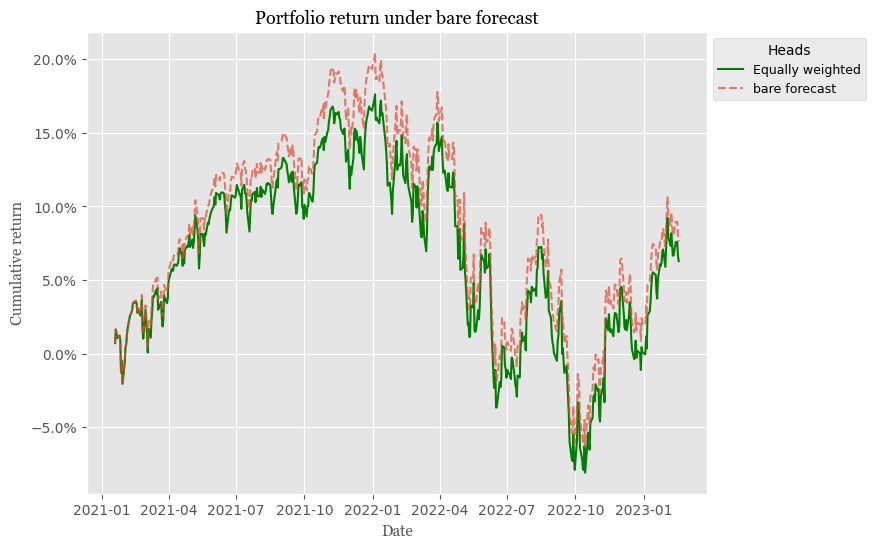

In [50]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 6))
_ = plt.plot(index, (ret.mean(1)+1).cumprod()- 1, color='green', label='Equally weighted')


_ = plt.plot(index, (returns_+1).cumprod()- 1, label='bare forecast', alpha=0.7, linestyle='--')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Date', fontsize=11, fontname='Georgia')
plt.ylabel('Cumulative return', fontsize=11, fontname='Georgia')
plt.title('Portfolio return under bare forecast', fontsize=13, fontname='Georgia')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Heads', fontsize=9)
plt.show()

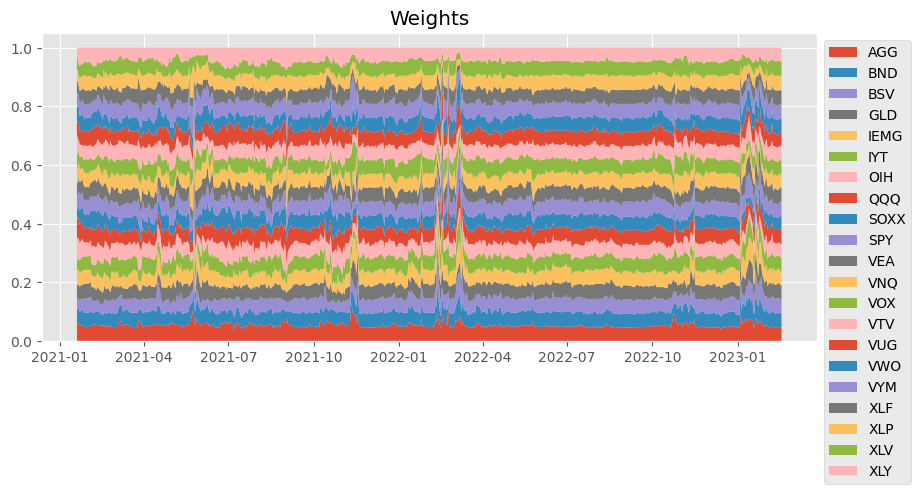

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
Communication with Neptune restored!
Communication with Neptune restored!
Communication with Neptune restored!
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterConnectionError
Communication with Neptune restored!
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
Communication with Neptune restored!
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: ConnectionError
Communic

In [55]:
plt.figure(figsize=(10, 4))
plt.stackplot(index, test_weights_matrix.T, labels=stocks)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Weights')
plt.show()

In [56]:
torch.save(model.state_dict(), f"model_bare_sr.pt")